In [51]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import keras
import cv2
import pickle
import sklearn
import scipy

from skimage import io
from skimage.transform import resize
from sklearn.metrics import auc, f1_score, roc_curve, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn import metrics
from google.colab import files
from keras.preprocessing import image
from keras.layers.serialization import activation
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import *
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import applications
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

#**Data directory**

In [ ]:
base_dir = '/content/drive/MyDrive/TIFF PET-CTWholeDataset'

training_set_dir = os.path.join(base_dir, 'trainingSet')
test_set_dir = os.path.join(base_dir, 'testSet')

train_lungCancer_dir = os.path.join(training_set_dir, 'lungCancer')
train_normal_dir = os.path.join(training_set_dir, 'normal')
test_lungCancer_dir = os.path.join(test_set_dir, 'lungCancer')
test_normal_dir = os.path.join(test_set_dir, 'normal')

In [ ]:
print('total training lungCancer images:', len(os.listdir(train_lungCancer_dir)))
print('total training normal images:', len(os.listdir(train_normal_dir)))
print('total test lungCancer images:', len(os.listdir(test_lungCancer_dir)))
print('total test normal images:', len(os.listdir(test_normal_dir)))

total training lungCancer images: 719
total training normal images: 726
total test lungCancer images: 199
total test normal images: 207


#**Checking patient overlap**

In [ ]:
def check_data_leakage(directory1, directory2):
    filenames_dir1 = set(os.listdir(directory1))
    filenames_dir2 = set(os.listdir(directory2))

    common_filenames = filenames_dir1.intersection(filenames_dir2)

    if len(common_filenames) > 0:
        print("Data leakage detected!")
        print("Common image filenames between the directories:", common_filenames)
    else:
        print("No data leakage detected.")

In [ ]:
check_data_leakage(train_lungCancer_dir, test_lungCancer_dir)
check_data_leakage(train_lungCancer_dir, test_normal_dir)
check_data_leakage(train_normal_dir, test_normal_dir)
check_data_leakage(train_normal_dir, test_lungCancer_dir)

No data leakage detected.
No data leakage detected.
No data leakage detected.
No data leakage detected.


#**Data generation**

In [32]:
BATCH_SIZE= 80
image_height, image_width = 245, 245

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  rotation_range= 15,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.1,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        training_set_dir,
        target_size=(image_height, image_width),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle = True)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
        test_set_dir,
        target_size=(image_height, image_width),
        batch_size=10,
        class_mode='categorical')

Found 1445 images belonging to 2 classes.
Found 406 images belonging to 2 classes.


#**Defining model**

In [33]:
pre_trained_model = InceptionV3(include_top=False,
                                        weights= 'imagenet',
                                        input_shape = (image_height, image_width, 3))

for layer in pre_trained_model.layers:
    layer.trainable = False

In [34]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 245, 245, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 122, 122, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 122, 122, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                      

In [36]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = GlobalAveragePooling2D()(last_output)

x = Flatten()(x)

x = Dense(2, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

last layer output shape:  (None, 6, 6, 2048)


In [37]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 245, 245, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 122, 122, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 122, 122, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                           

In [38]:
savingPath = os.makedirs('/content/sample_data/temporaryWeights')
checkpoint_path = '/content/sample_data/temporaryWeights'
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, verbose= 1)

/content/sample_data/temporaryWeights


In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), loss= 'categorical_crossentropy',
              metrics= [tf.keras.metrics.BinaryAccuracy(name="Binary_accuracy"),
                        tf.keras.metrics.Precision(name='Precision'),
                        tf.keras.metrics.Recall(name='Recall'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.AUC(name='AUC')])

In [41]:
history = model.fit(
            train_generator,
            validation_data = test_generator,
            epochs = 20,
            verbose = 1,
            callbacks = [cp_callback])

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 0.1622 - Binary_accuracy: 0.9377 - Precision: 0.9377 - Recall: 0.9377 - TP: 1355.0000 - TN: 1355.0000 - FN: 90.0000 - FP: 90.0000 - AUC: 0.9848
Epoch 1: val_loss did not improve from 0.26383
19/19 [==============================] - 31s 2s/step - loss: 0.1622 - Binary_accuracy: 0.9377 - Precision: 0.9377 - Recall: 0.9377 - TP: 1355.0000 - TN: 1355.0000 - FN: 90.0000 - FP: 90.0000 - AUC: 0.9848 - val_loss: 0.3261 - val_Binary_accuracy: 0.8547 - val_Precision: 0.8547 - val_Recall: 0.8547 - val_TP: 347.0000 - val_TN: 347.0000 - val_FN: 59.0000 - val_FP: 59.0000 - val_AUC: 0.9424
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 0.1626 - Binary_accuracy: 0.9336 - Precision: 0.9336 - Recall: 0.9336 - TP: 1349.0000 - TN: 1349.0000 - FN: 96.0000 - FP: 96.0000 - AUC: 0.9843
Epoch 2: val_loss did not improve from 0.26383
19/19 [==============================] - 28s 1s/step - loss: 0.1626 - Binary_accuracy: 0.93

##**LoadingWeightsofTheInceptionV3Model**

In [44]:
model2 = Model(pre_trained_model.input, x)

In [45]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= [tf.keras.metrics.BinaryAccuracy(name="Binary_accuracy"),
                        tf.keras.metrics.Precision(name='Precision'),
                        tf.keras.metrics.Recall(name='Recall'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.AUC(name='AUC')])

In [46]:
model2.load_weights(checkpoint_path)

In [47]:
model2.evaluate(test_generator)

41/41 [==============================] - 7s 104ms/step - loss: 0.3732 - Binary_accuracy: 0.8670 - Precision: 0.8670 - Recall: 0.8670 - TP: 352.0000 - TN: 352.0000 - FN: 54.0000 - FP: 54.0000 - AUC: 0.9572


[0.3732220530509949,
 0.866995096206665,
 0.866995096206665,
 0.866995096206665,
 352.0,
 352.0,
 54.0,
 54.0,
 0.9571755528450012]

##**Heatmap for uploaded PET/CT images from a cloud drive**

1/1 [==============================] - 0s 27ms/step


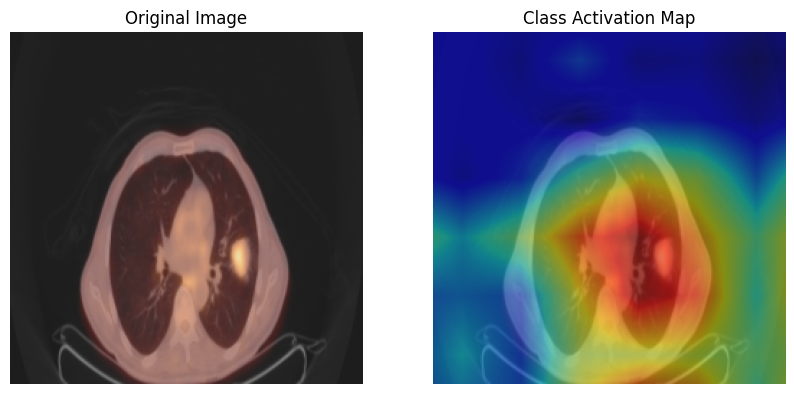

1/1 [==============================] - 0s 26ms/step


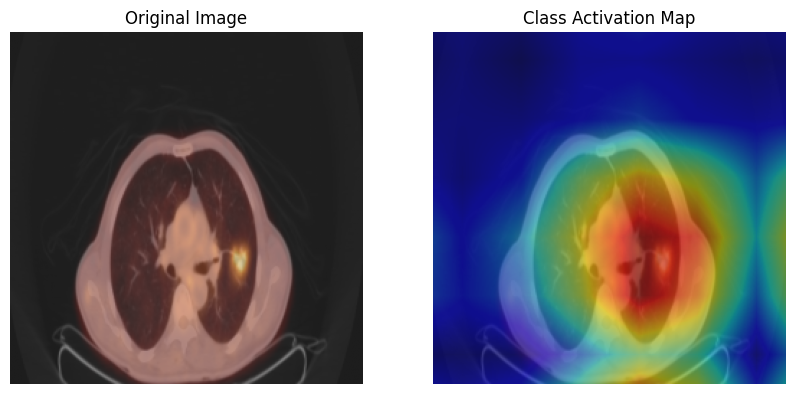

1/1 [==============================] - 0s 26ms/step


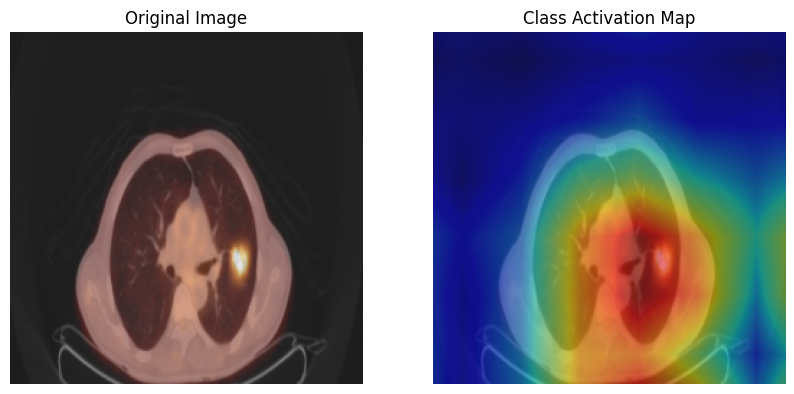

1/1 [==============================] - 0s 46ms/step


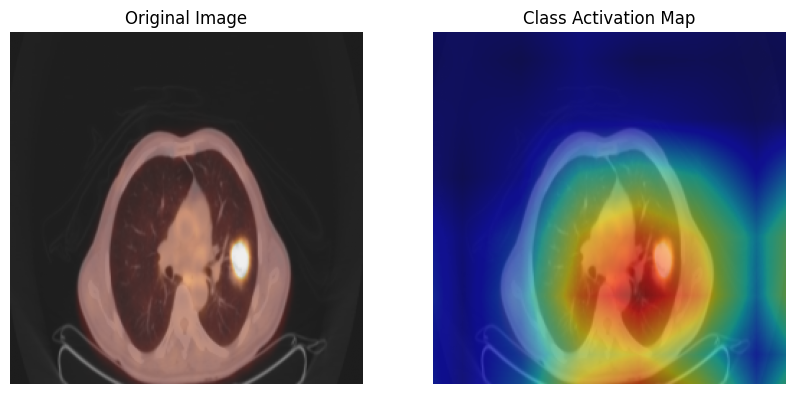

1/1 [==============================] - 0s 26ms/step


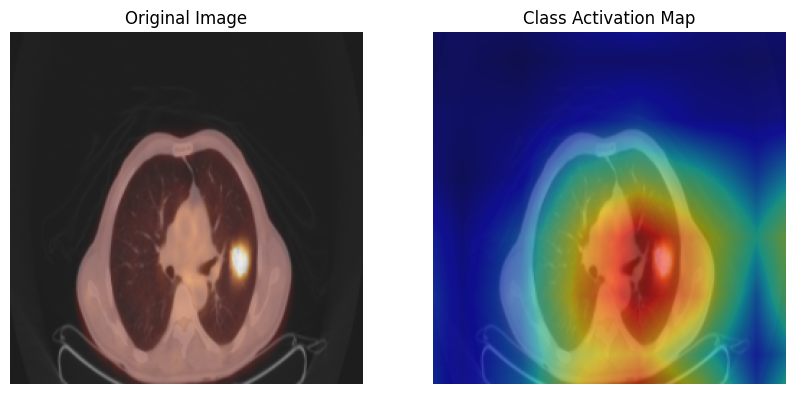

1/1 [==============================] - 0s 26ms/step


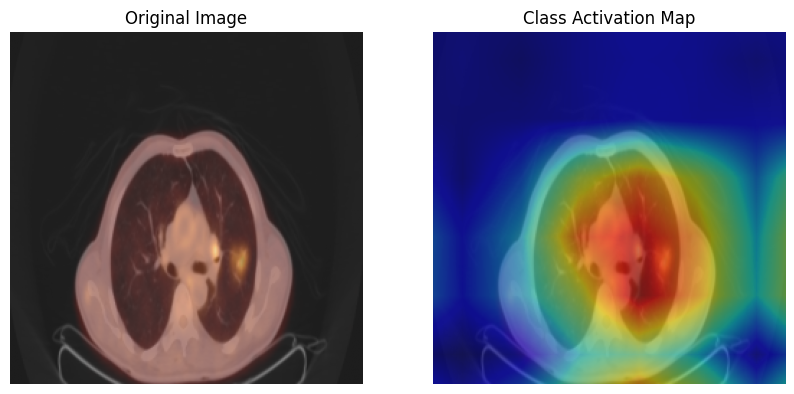

1/1 [==============================] - 0s 27ms/step


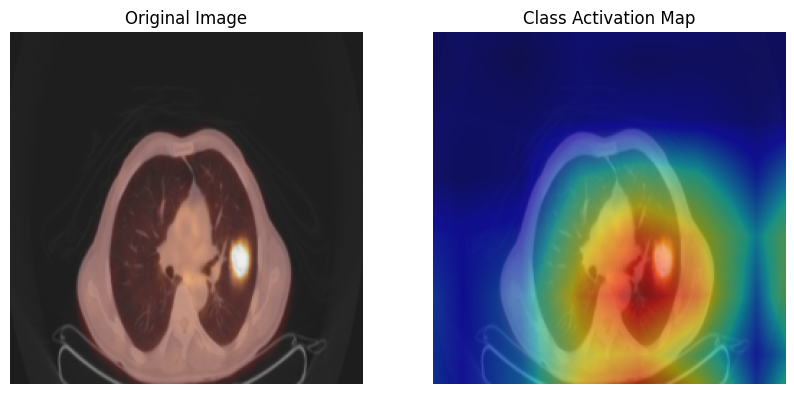

In [68]:
# Load your trained model
loaded_model = model

output_directory = '/content/sample_data'

fileNames = os.listdir('/content/sample_data/patient1')
filePaths = []


for i in fileNames:
    path = '/content/sample_data/patient1/'
    new_path = path + i
    filePaths.append(new_path)

for fn in filePaths:
    img = io.imread(fn)
    img_resized = resize(img, (image_height, image_width), anti_aliasing=True) 
    img_array = tf.keras.preprocessing.image.img_to_array(img_resized)
    img_tensor = np.expand_dims(img_array, axis=0)

    predictions = loaded_model.predict(img_tensor)
    label_index = np.argmax(predictions)

    class_weights = loaded_model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]
    final_conv_layer = loaded_model.get_layer("mixed10")

    get_output = K.function([loaded_model.layers[0].input], [final_conv_layer.output, loaded_model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img_tensor])
    conv_outputs = np.squeeze(conv_outputs)

    target_size = final_conv_layer.output_shape[1:3]  
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (target_size[0] / conv_outputs.shape[0], target_size[1] / conv_outputs.shape[1], 1), order=1)

    cam = np.dot(mat_for_mult.reshape((-1, conv_outputs.shape[-1])), class_weights_winner).reshape(target_size)
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    cam_resized = resize(cam, img_resized.shape[:2], mode='reflect', anti_aliasing=True)

    heatmap = plt.cm.jet(cam_resized)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_resized)
    axes[0].axis('off')
    axes[0].set_title('Original Image')
    axes[1].imshow(img_resized)
    axes[1].imshow(heatmap, alpha=0.5)
    axes[1].axis('off')
    axes[1].set_title('Class Activation Map')
    plt.show()

    filename = fn.split('/')[-1].split('.')[0]  
    save_path = f"{output_directory}{filename}_heatmap.png"

    fig.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.close(fig)  
